In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utils

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x, axis=1):
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis=axis, keepdims=True)
  
def multiclass_cross_entropy(target, p_hat):
    # target = [[0, 1, 0], [0, 0, 1]]
    # p_hat = [[0.04, 0.95, 0.01], [0.1, 0.8, 0.1]]
    # returns [-0.05129329, -2.30258509]
    assert isinstance(p_hat, np.ndarray)
    assert isinstance(target, np.ndarray)
    assert target.shape == p_hat.shape
    assert len(target.shape) == 2 and target.shape[1] > 1
    log_p = np.log(p_hat[np.nonzero(target)])
    return -log_p.mean()

def r2(y, y_hat):
    assert isinstance(y, np.ndarray)
    assert isinstance(y_hat, np.ndarray)
    return 1 - sse(y, y_hat) / sse(y, np.array([y.mean()]))

def sse(y, y_hat):
    assert isinstance(y, np.ndarray)
    assert isinstance(y_hat, np.ndarray)
    assert len(y.shape) == 1 or y.shape[1] == 1
    err = (y - y_hat).flatten()
    result = err.dot(err)
    return result

def mse(y, y_hat):
    return sse(y, y_hat) / len(y)

def accuracy(target, y_hat):
    assert isinstance(y_hat, np.ndarray)
    assert isinstance(target, np.ndarray)
    assert target.shape == y_hat.shape
    assert len(target.shape) == 1 or len(target.shape) == 2
    if len(target.shape) == 1:
        return (y_hat == target).mean()
    if len(target.shape) == 2:
        target_ind = one_hot_2_vec(target)
        y_hat_ind = one_hot_2_vec(y_hat)
        return (target_ind == y_hat_ind).mean()
  
def ndarray_one_hot_encode(vec, width):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 1
    n = vec.shape[0]
    mat = np.zeros((n, width))
    mat[np.arange(n), vec] = 1
    return mat

def one_hot_2_vec(vec):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 2
    return np.argmax(vec, axis=1)

# Generic ANN sequential model with configurable Layers

In [3]:
class Activation:
    @staticmethod
    def value(x):
        pass

    @staticmethod
    def derivative(x):
        pass

    @staticmethod
    def backprop_derivative(x):
        pass


class SigmoidActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return sigmoid(x)

    @staticmethod
    def derivative(x):
        simg_x = sigmoid(x)
        return simg_x * (1 - simg_x)

    @staticmethod
    def backprop_derivative(x):
        return x * (1 - x)


class TanhActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        ex = np.exp(x)
        e_x = np.exp(-x)
        return (ex - e_x) / (ex + e_x)

    @staticmethod
    def derivative(x):
        tanh_x = TanhActivation.value(x)
        return 1 - tanh_x * tanh_x

    @staticmethod
    def backprop_derivative(x):
        return 1 - x * x


class ReLUActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return x * ReLUActivation._step_fun(x)

    @staticmethod
    def derivative(x):
        return ReLUActivation._step_fun(x)

    @staticmethod
    def backprop_derivative(x):
        return ReLUActivation._step_fun(x)

    def _step_fun(x):
        result = np.zeros(x.shape)
        result[x > 0] = 1
        return result


class IdentityActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return x

    @staticmethod
    def derivative(x):
        return x

    @staticmethod
    def backprop_derivative(x):
        return x


class SoftmaxActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return softmax(x, axis=1)

    @staticmethod
    def derivative(x):
        softmax_x = softmax(x, axis=1)
        return softmax_x * (1 - softmax_x)

    @staticmethod
    def backprop_derivative(x):
        raise NotImplemented()


In [4]:
class Layer:
    def __init__(self, imput_dim, output_dim):
        assert imput_dim is not None
        assert output_dim is not None
        self._input_dim = imput_dim
        self._output_dim = output_dim

    def forward(self, z):
        pass

    def initialize_params(self):
        pass

    def update_params(self, learning_rate, delta, z):
        pass

    def propagate_delta_back(self, delta):
        pass

    def calc_gradient_delta(self, delta, z):
        pass


class DenseLayer(Layer):
    def __init__(self, imput_dim, output_dim, activation, init_params=None):
        super().__init__(imput_dim, output_dim)
        if activation is not None:
            assert isinstance(activation, Activation)
        self.activation = activation
        if init_params is not None:
            assert len(init_params) == 2
            self.weights, self.biases = init_params
        else:
            self.initialize_params()

    def forward(self, x):
        assert x.shape[1] == self._input_dim
        a = x.dot(self.weights) + self.biases
        if self.activation is None:
            out = a
        else:
            out = self.activation.value(a)
        if self._output_dim == 1:
            assert out.shape[0] == x.shape[0]
            out = out.reshape(-1, self._output_dim)
        else:
            assert out.shape == (x.shape[0], self._output_dim)
        return out

    @staticmethod
    def _dw(z, err):
        return z.T.dot(err)

    @staticmethod
    def _db(err):
        return np.sum(err, axis=0)

    def initialize_params(self):
        self.weights = np.random.randn(self._input_dim, self._output_dim) / np.sqrt(self._output_dim)
        self.biases = np.random.randn(self._output_dim)

    def update_params(self, learning_rate, delta, z):
        d_w = z.T.dot(delta)
        d_b = np.sum(delta, axis=0)
        self.weights = self.weights + learning_rate * d_w
        self.biases = self.biases + learning_rate * d_b

    def propagate_delta_back(self, delta):
        if len(delta.shape) == 1 and len(self.weights.shape) == 1:
            result = np.outer(delta, self.weights)
        else:
            assert len(delta.shape) == 2 and len(self.weights.shape) == 2
            assert delta.shape[1] == self.weights.T.shape[0]
            result = delta.dot(self.weights.T)
        return result

    def calc_gradient_delta(self, delta, z):
        result = delta * self.activation.backprop_derivative(z)
        return result


In [5]:
class NNSequential:
    def __init__(self, layers, n_steps, learning_rate=0.001, plot_training_history=False):
        self.layers = layers
        self._n_steps = n_steps
        self._learning_rate = learning_rate
        self._fit_history = None
        self._plot_training_history = plot_training_history
        self.fit_history = None

    def fit(self, X, Y):
        pass

    def predict(self, X):
        pass

    def score(self, X, Y):
        pass

    def _fit_prepare(self, X, Y):
        assert isinstance(X, np.ndarray) and len(X.shape) == 2
        assert isinstance(Y, np.ndarray)
        assert X.shape[0] == Y.shape[0]
        self.fit_history = []

    def _backward(self, x, y):
        # print(f'-------------step 0-------------')
        feature_values_by_layer = self._forward(x)
        self._calc_fit_scores(y, feature_values_by_layer[-1])

        for step in range(1, self._n_steps + 1):
            # print(f'-------------step {step}-------------')
            self._update_params(y, feature_values_by_layer)

            feature_values_by_layer = self._forward(x)
            self._calc_fit_scores(y, feature_values_by_layer[-1])

        hist = np.array(self.fit_history)
        if self._plot_training_history:
            self._plot_history(hist)

        return hist

    def _plot_history(self, history):
        pass

    def _calc_fit_scores(self, forward_result, p_hat):
        pass

    def _update_params(self, y, z_by_layers):
        n_layers = len(self.layers)

        deltas = []
        deltas.append(y - z_by_layers[-1])
        for l_idx in reversed(range(n_layers - 1)):
            current_layer = self.layers[l_idx]
            current_layer_z = z_by_layers[l_idx + 1]
            following_layer = self.layers[l_idx + 1]
            following_layer_delta = deltas[-1]

            back_propagated_delta = following_layer.propagate_delta_back(following_layer_delta)
            deltas.append(current_layer.calc_gradient_delta(back_propagated_delta,  current_layer_z))
        deltas.reverse()

        for l_idx in range(n_layers):
            layer = self.layers[l_idx]
            layer.update_params(self._learning_rate, deltas[l_idx], z_by_layers[l_idx])

    def _forward(self, x):
        out_feature_values_by_layer = [x]
        z = x
        for layer in self.layers:
            z = layer.forward(z)
            out_feature_values_by_layer.append(z)
        return out_feature_values_by_layer


class NNSequentialClassifier(NNSequential):
    def __init__(self, layers, n_steps, n_classes=None, learning_rate=0.001,
                 plot_training_history=False):
        super().__init__(layers, n_steps, learning_rate, plot_training_history)
        self._K = n_classes
        self._target_label_size = None

    def fit(self, X, Y):
        super()._fit_prepare(X, Y)

        if len(Y.shape) == 1:
            print('Assume targets is 1d array with values corresponding to K classes')
            Y_Kd = ndarray_one_hot_encode(Y, self._K)
            self._target_label_size = 1
        else:
            print('Assume targets is one hot encoded Kd array with columns corresponding to K classes')
            assert np.all(Y.sum(axis=1) == np.ones(Y.shape[0]))
            Y_Kd = Y
            self._target_label_size = Y_Kd.shape[1]

        if self._K is None:
            self._K = len(set(Y))

        return self._backward(X, Y_Kd)

    def predict(self, X):
        assert isinstance(X, np.ndarray)
        y_hat_ind = self._predict_ind(X)
        if self._target_label_size == 1:
            return y_hat_ind
        else:
            return ndarray_one_hot_encode(y_hat_ind, self._target_label_size)

    def _predict_ind(self, X):
        layers_output = self._forward(X)
        p_hat = layers_output[-1]
        return np.argmax(p_hat, axis=1)

    def score(self, X, Y):
        assert isinstance(X, np.ndarray)
        assert isinstance(Y, np.ndarray)
        assert X.shape[0] == Y.shape[0]
        if self._target_label_size == 1:
            assert len(Y.shape) == 1
            T_ind = Y
        else:
            assert len(Y.shape) == 2 and Y.shape[1] > 1
            T_ind = one_hot_2_vec(Y)
        y_hat_ind = self._predict_ind(X)
        return self._accuracy_ind(T_ind, y_hat_ind)

    @staticmethod
    def _accuracy_ind(target, y_hat_ind):
        return (target == y_hat_ind).mean()

    def _calc_fit_scores(self, y, p_hat):
        loss = multiclass_cross_entropy(y, p_hat)
        acc = self._accuracy_ind(np.argmax(y, axis=1), np.argmax(p_hat, axis=1))
        self.fit_history.append(np.array([loss, acc]))

    def _plot_history(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(-1 * history[:, 0], label='loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(history[:, 1], label='accuracy')
        plt.legend()
        plt.show()
        print(f'final cost={history[-1, 0]}, final accuracy={history[-1, 1]}')


class NNSequentialRegressor(NNSequential):
    def __init__(self, layers, n_steps, learning_rate=0.001, plot_training_history=False):
        super().__init__(layers, n_steps, learning_rate, plot_training_history)

    def fit(self, X, Y):
        super()._fit_prepare(X, Y)
        assert len(Y.shape) == 1 or (len(Y.shape) == 2 and Y.shape[1] == 1)
        self._initial_target_shape = Y.shape
        return self._backward(X, Y.reshape(-1, 1))

    def predict(self, X):
        assert isinstance(X, np.ndarray)
        layers_out = self._forward(X)
        y_hat = layers_out[-1]
        assert len(y_hat.shape) == 2 and y_hat.shape[1] == 1
        if len(self._initial_target_shape) == 1:
            return y_hat.flatten()
        else:
            return y_hat.reshape(-1, 1)

    def score(self, X, Y):
        assert isinstance(X, np.ndarray)
        assert isinstance(Y, np.ndarray)
        assert X.shape[0] == Y.shape[0]
        y_hat = self.predict(X)
        return mse(Y, y_hat)

    def _calc_fit_scores(self, y, y_hat):
        y_hat = y_hat.reshape(y.shape)
        loss = mse(y, y_hat)
        R2 = r2(y, y_hat)
        self.fit_history.append(np.array([loss, R2]))

    def _plot_history(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(-1 * history[:, 0], label='mse')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(history[:, 1], label='R2')
        plt.legend()
        plt.show()
        print(f'final cost MSE={history[-1, 0]}, final R2={history[-1, 1]}')


# Use ANN Sequential model for classification


## for generated clouds data

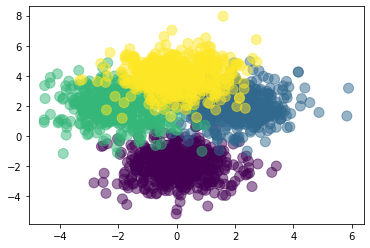

generated w0=[[-0.1892389  -2.08439285  0.96040811]
 [-0.61886954 -0.83015723  0.00492278]]
generated b0=[ 1.52356278  0.18288512 -1.57282414]
generated w1=[[-1.49665625  0.66329887 -1.6586164  -0.1787166 ]
 [-0.68036961  0.8514299   0.03703866 -0.91822225]
 [ 0.38017221  1.40543075  1.06674083 -0.18627291]]
generated b1=[ 1.00744671  0.35992143 -0.62329776  1.62050285]


In [6]:
def det_simple_cloud_data(Nclass):
  X1 = np.random.randn(Nclass, 2) + np.array([0, -2])
  X2 = np.random.randn(Nclass, 2) + np.array([2, 2])
  X3 = np.random.randn(Nclass, 2) + np.array([-2, 2])
  X4 = np.random.randn(Nclass, 2) + np.array([0, 4])
  X = np.vstack([X1, X2, X3, X4])

  Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass + [3]*Nclass)
  return X, Y

Xtrain, Ytrain = det_simple_cloud_data(500)
Xtest, Ytest = det_simple_cloud_data(100)

plt.scatter(Xtrain[:,0], Xtrain[:, 1], c=Ytrain, s=100, alpha=0.5)
plt.show()

D = 2  # dimensionality of input
M1 = 3  # hidden layer size
M2 = 5  # hidden layer size
K = 4  # number of classes

Ttrain = ndarray_one_hot_encode(Ytrain, K)
Ttest = ndarray_one_hot_encode(Ytest, K)

W1 = np.random.randn(D, M1)
b1 = np.random.randn(M1)
W2 = np.random.randn(M1, K)
b2 = np.random.randn(K)
print(f'generated w0={W1}')
print(f'generated b0={b1}')
print(f'generated w1={W2}')
print(f'generated b1={b2}')

### for 2 layer NN

Assume targets is 1d array with values corresponding to K classes


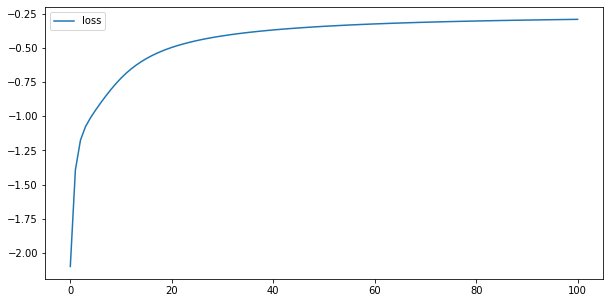

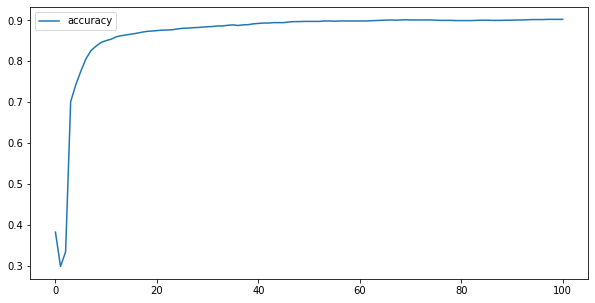

final cost=0.2911522968886804, final accuracy=0.9025


final 2 layers model w0=[[ 1.92315681 -1.69615331  1.66829218]
 [-1.59856271 -1.52185684  1.00003982]]
final 2 layers model b0=[ 2.06659509  2.20533072 -1.90430602]
final 2 layers model w1=[[ 2.96975375  2.17878056 -4.23685057 -3.58237414]
 [ 1.87013794 -2.31391594  3.07642182 -3.34276712]
 [-1.34507357  3.22005052 -0.31573901  1.10683294]]
final 2 layers model b1=[-1.31122777 -0.85201671  1.20767668  3.32014104]


Train accuracy in 2 layers nn: 0.9025
Test accuracy in 2 layers nn: 0.8825


In [7]:
l0 = DenseLayer(D, M1, SigmoidActivation(), init_params=[W1, b1])
l1 = DenseLayer(M1, K, SoftmaxActivation(), init_params=[W2, b2])

model2l = NNSequentialClassifier(layers=[l0, l1], n_steps=100, n_classes=K, plot_training_history=True)

model2l.fit(Xtrain, Ytrain)
assert model2l.score(Xtrain, model2l.predict(Xtrain)) == 1

print('\n')
print(f'final 2 layers model w0={model2l.layers[0].weights}')
print(f'final 2 layers model b0={model2l.layers[0].biases}')
print(f'final 2 layers model w1={model2l.layers[1].weights}')
print(f'final 2 layers model b1={model2l.layers[1].biases}')

print('\n')
print('Train accuracy in 2 layers nn:', model2l.score(Xtrain, Ytrain))
print('Test accuracy in 2 layers nn:', model2l.score(Xtest, Ytest))

### for 3 layer NN

Assume targets is 1d array with values corresponding to K classes


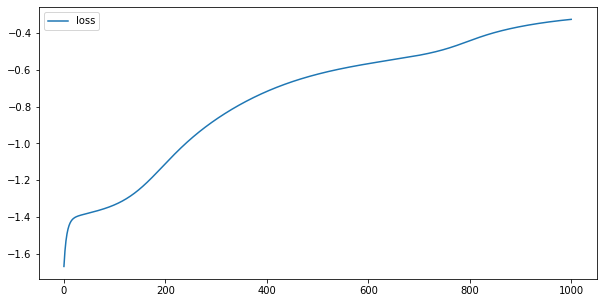

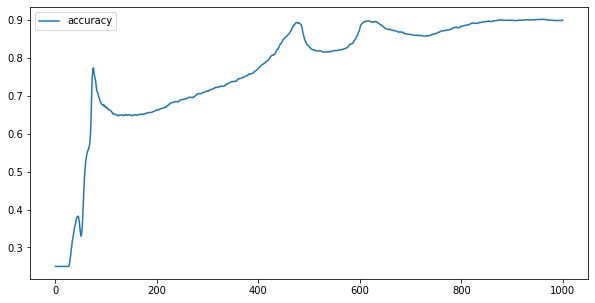

final cost=0.3269064749860136, final accuracy=0.899


final 3 layers model w0=[[-0.14925082  1.59163322  2.04420217]
 [-1.13745719  1.01467835 -1.20512787]]
final 3 layers model b0=[ 0.28675671 -1.16088707  1.3016165 ]
final 3 layers model w1=[[-0.74446292 -1.28474252 -0.99191683 -0.15734351  2.06125259]
 [ 1.15199452  2.09871468 -0.61043321  0.00619672 -3.78631858]
 [-1.53248495  1.27970767 -0.33550332 -4.470719    1.57814769]]
final 3 layers model b1=[-0.28960239 -1.02620416 -2.06836954  1.66442333  0.3705674 ]
final 3 layers model w2=[[-1.12459619 -0.80834983 -0.2090596   1.9447302 ]
 [-1.25421406  2.08858835 -2.48743172  0.31806467]
 [-0.20784291 -0.02762735 -0.39704108  0.09738248]
 [-2.09581485 -2.8654772   3.73639029  2.35478598]
 [ 5.19000652 -1.78313084  0.29336863 -3.17575011]]
final 3 layers model b2=[-1.62789835  0.63026935 -0.65255058 -1.27173697]


Train accuracy in 3 layers nn: 0.899
Test accuracy in 3 layers nn: 0.8875


In [8]:
l0 = DenseLayer(D, M1, SigmoidActivation())#, init_params=[W1, b1])
l1 = DenseLayer(M1, M2, SigmoidActivation())#, init_params=[W2_2, b2_2])
l2 = DenseLayer(M2, K, SoftmaxActivation())#, init_params=[W3_2, b3_2])
model3l = NNSequentialClassifier(layers=[l0, l1, l2], learning_rate=0.0001, n_steps=1000, n_classes=K, plot_training_history=True)

model3l.fit(Xtrain, Ytrain)
assert model3l.score(Xtrain, model3l.predict(Xtrain)) == 1

print('\n')
print(f'final 3 layers model w0={model3l.layers[0].weights}')
print(f'final 3 layers model b0={model3l.layers[0].biases}')
print(f'final 3 layers model w1={model3l.layers[1].weights}')
print(f'final 3 layers model b1={model3l.layers[1].biases}')
print(f'final 3 layers model w2={model3l.layers[2].weights}')
print(f'final 3 layers model b2={model3l.layers[2].biases}')

print('\n')
print('Train accuracy in 3 layers nn:', model3l.score(Xtrain, Ytrain))
print('Test accuracy in 3 layers nn:', model3l.score(Xtest, Ytest))

# Use ANN Sequential model for regression

In [11]:
def get_simple_saddle_data(N):
    X = np.random.random((N, 2)) * 4 - 2  # in between (-2, +2)
    Y = X[:, 0] * X[:, 1]  # makes a saddle shape
    return X, Y


def run_regression_saddle(Xtrain, Xtest, Ytrain, Ytest, plot_training_history=True):
    D = 2
    M = 100
    M1 = 100
    K = 1

    # 3 layers NN regressor
    W1 = np.random.randn(D, M) / np.sqrt(D)
    b1 = np.random.randn(M)
    W2 = np.random.randn(M, M1) / np.sqrt(M)
    b2 = np.random.randn(M1)
    Wn = np.random.randn(M1, 1) / np.sqrt(M)
    bn = 0
    l0 = DenseLayer(D, M, ReLUActivation(), init_params=[W1, b1])
    l1 = DenseLayer(M, M1, SigmoidActivation(), init_params=[W2, b2])
    ln = DenseLayer(M1, K, IdentityActivation(), init_params=[Wn, bn])
    model = NNSequentialRegressor(layers=[l0, l1, ln], n_steps=10000, learning_rate=1e-5,
                                  plot_training_history=plot_training_history)

    model.fit(Xtrain, Ytrain)
    assert model.score(Xtrain, model.predict(Xtrain)) == 0

    # print('\n')
    # print(f'final 3 layers model w0={model.layers[0].weights}')
    # print(f'final 3 layers model b0={model.layers[0].biases}')
    # print(f'final 3 layers model w1={model.layers[1].weights}')
    # print(f'final 3 layers model b1={model.layers[1].biases}')
    # print(f'final 3 layers model w2={model.layers[2].weights}')
    # print(f'final 3 layers model b2={model.layers[2].biases}')
    print('\n')
    print('Train MSE in 3 layers nn:', model.score(Xtrain, Ytrain))
    print('Test MSE in 3 layers nn:', model.score(Xtest, Ytest))


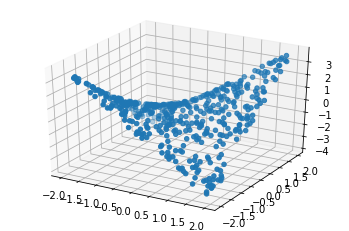

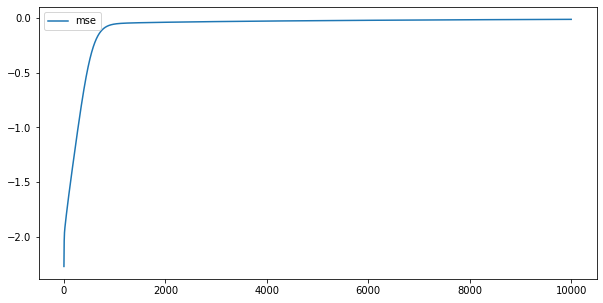

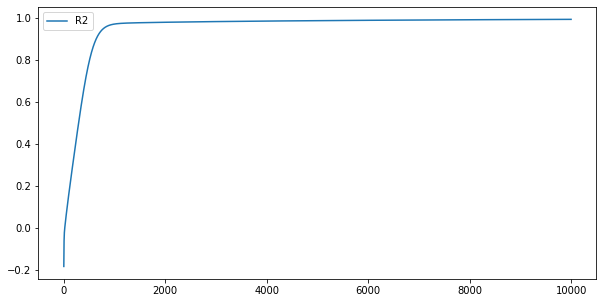

final cost MSE=0.013093368650756004, final R2=0.9931782252305511


Train MSE in 3 layers nn: 0.013093368650756004
Test MSE in 3 layers nn: 0.01592357521341211


In [12]:
Xtrain, Ytrain = get_simple_saddle_data(500)
Xtest, Ytest = get_simple_saddle_data(100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xtrain[:, 0], Xtrain[:, 1], Ytrain)
plt.show()

run_regression_saddle(Xtrain, Xtest, Ytrain, Ytest, plot_training_history=True)